## Missing data and imputation
In this notebook, we conduct a simple experiment to highlight advantages
and disadvantages of methods for data imputation.
We will benchmark mean / mode / median / constant imputation as well as
a k-NN-based hot-deck imputation and MICE.

Some imports

In [47]:
"""Sandbox for notebook"""
# base imports
import os
import time

# exploratory data analysis
import missingno, pandas_profiling

# data processing
import numpy as np
import pandas as pd

# datasets/training/imputation
import sklearn
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# autoML
import h2o
from h2o.automl import H2OAutoML

# imputation
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import impyute, fancyimpute, autoimpute, missingpy, datawig
from fancyimpute import KNN
from datawig import SimpleImputer as DWSimpleImputer

# visualisation
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Some settings

In [48]:
# plot styling
%matplotlib inline
sns.set_context("talk")
sns.set_style("darkgrid", {"legend.frameon": True})

# working directory
try:
    # inside try to be able to easily run stuff on ipython as well
    BASE_DIR = os.path.join(os.path.abspath(os.path.dirname(__file__)), "..")
except NameError:
    BASE_DIR = "../"

Utility functions for loading different data sets


In [3]:
def load_data():
    data = datasets.load_iris()
    # data = datasets.load_diabetes()
    # data = datasets.load_digits()
    df = pd.DataFrame(data.data)
    if "feature_names" in data:
        df.columns = data.feature_names

    df["target"] = data.target
    # df["label_name"] = [iris.target_names[it] for it in iris.target]
    return df.iloc[:, :-1], df.iloc[:, -1]


def load_census():

    CAT = "category"
    CONT = np.float32

    col_names = [
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        ">50k",
    ]

    dtypes = [
        np.int16,
        CAT,
        CONT,
        CAT,
        CONT,
        CAT,
        CAT,
        CAT,
        CAT,
        CAT,
        CONT,
        CONT,
        CONT,
        CAT,
        CAT,
    ]
    df = pd.read_csv(
        os.path.join(BASE_DIR, "data", "adult.data"),
        sep=",",
        names=col_names,
        dtype={k: v for (k, v) in zip(col_names, dtypes)},
    )

    df = df.sample(n=1000)

    df = pd.get_dummies(df, drop_first=True)
    return df.iloc[:, :-1], df.iloc[:, -1]
    # return df


def load_wine():
    df = pd.read_csv(os.path.join(BASE_DIR, "data", "winequality-white.csv"), sep=";")
    return df.iloc[:, :-1], df.iloc[:, -1]


def load_breast_cancer():
    data = datasets.load_breast_cancer()
    df = pd.DataFrame(data.data)
    df.columns = data.feature_names
    df["target"] = data.target
    return df.iloc[:, :-1], df.iloc[:, -1]

Methods for deleting points - both MCAR and MAR

In [4]:
# introduce missingness - missing completely at random
def delete_datapoints(X, columns=None, frac=0.1):
    _X = X.copy(deep=True)

    if columns is None:
        columns = _X.columns

    if isinstance(columns, str):
        columns = [columns]

    for col in columns:
        nan_idx = _X.sample(frac=frac).index
        _X.loc[nan_idx, col] = np.NaN

    return _X

# introduce missingness - missing at random
def delete_datapoints_mar(X, y, columns=None, frac=0.1):
    _X = X.copy(deep=True)

    if columns is None:
        columns = _X.columns

    if isinstance(columns, str):
        columns = [columns]

    # set different fractions of missing data depending on the median of the response variable
    for col in columns:
        nan_idx_1 = _X[y >= np.nanmedian(y)].sample(frac=max(frac - 0.15, 0)).index
        nan_idx_2 = _X[y < np.nanmedian(y)].sample(frac=min(frac + 0.15, 1)).index
        for indices in [nan_idx_1, nan_idx_2]:
            _X.loc[indices, col] = np.NaN
    return _X

Function for data imputation:

In [7]:
def impute_data(X, columns=None, strategy="mean", **strategy_kwargs):
    _X = X.copy(deep=True)

    # TODO: complete case is no imputation strategy...
    if strategy == "complete_case":
        return _X.dropna()

    strategy_dict = {
        # use lambda to avoid premature initialisation
        "mean": lambda: SimpleImputer(missing_values=np.NaN, strategy="mean"),
        "median": lambda: SimpleImputer(missing_values=np.NaN, strategy="median"),
        "most_frequent": lambda: SimpleImputer(
            missing_values=np.NaN, strategy="most_frequent"
        ),
        "zero": lambda: SimpleImputer(
            missing_values=np.NaN, strategy="constant", fill_value=0
        ),
        "hot-deck": lambda: None,
        "knn": lambda: KNN(**strategy_kwargs),
        "mice": lambda: IterativeImputer(
            max_iter=10, sample_posterior=True, **strategy_kwargs
        ),
        "datawig": lambda: DWSimpleImputer
    }

    if columns is None:
        columns = _X.columns

    imputer = strategy_dict[strategy]()

    if strategy == "datawig":
        _X = imputer.complete(_X)
    else:
        _X.loc[:, columns] = imputer.fit_transform(_X.loc[:, columns])
    return _X

Benchmarking experiment code:

In [18]:
def experiment(
    X,
    y,
    model=None,
    metric=None,
    reps=3,
    missing_fracs=None,
    impute_params=None,
    missingness="mcar",
):

    if missing_fracs is None:
        missing_fracs = np.linspace(0.0, 0.9, 5)

    if impute_params is None:
        impute_params = [
            ("complete_case", {}),
            ("mean", {}),
            ("median", {}),
            # ("most_frequent", {}),
            # ("zero", {}),
            # TODO: problem if user wants to try different knn (with different k)
            #  => store strategy and some indicator!
            ("knn", {"k": 3, "verbose": False}),
            ("mice", {}),
            # ("datawig", {})
        ]

    results = {"exp_rep": [], "missing_frac": [], "strategy": [], "metric_score": []}

    # print("Split into train and validation set")

    # TODO: same split for all repetitions? or resplit?
    #  Better: use CV
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

    # print("Evaluating different imputation methods w.r.t. model accuracy")

    for rep in range(reps):
        # print("\n\n========== Experiment instance %s ==========" % rep)
        for missing_frac in missing_fracs:
#             print(
#                 "\n========== Missing percentage %s%% =========="
#                 % int(missing_frac * 100)
#             )
            if missingness == "mar":
                # print("MAR setting")
                X_train_miss = delete_datapoints_mar(
                    X_train, y_train, frac=missing_frac
                )
            else:
                # print("defaulting to MCAR setting")
                X_train_miss = delete_datapoints(X_train, frac=missing_frac)

            for (impute_strategy, impute_param) in impute_params:
                # print("========== Imputation strategy %s ==========" % impute_strategy)
                try:
                    X_train_imputed = impute_data(
                        X_train_miss, strategy=impute_strategy, **impute_param
                    )
                    y_train_imputed = y_train.loc[X_train_imputed.index]

                    # print("Retrain model on imputed data")
                    model.fit(X_train_imputed, y_train_imputed)
                    # make use of metric
                    y_pred = model.predict(X_test)
                    metric_score = metric(y_test, y_pred)
                except ValueError as e:
#                     print(
#                         "Could not train model or compute accuracy. Continue to next training instance."
#                     )
#                     print(e)
                    continue
                # print("Metric score: %s" % metric_score)

                results["exp_rep"].append(rep)
                results["missing_frac"].append(missing_frac)
                results["strategy"].append(impute_strategy)
                results["metric_score"].append(metric_score)

    return pd.DataFrame(results)

Some utility function for plotting:

In [9]:
def feature_col_vs_metric_score(
    results_df,
    feature_col="missing_frac",
    metric_score="metric_score",
    group_col="strategy",
):
    """
    How does each model perform based on a single feature (averaged across other relevant features) wrt a metric score
    :param group_col:
    :param results_df:
    :param feature_col:
    :param metric_score:
    :return:
    """
    return sns.lineplot(
        x=feature_col,
        y=metric_score,
        hue=group_col,
        style=group_col,
        markers=True,
        dashes=False,
        data=results_df,
    )

Running first Experiment

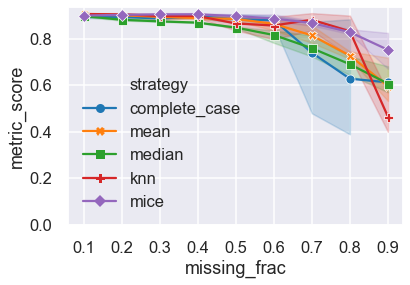

In [49]:
X, y = load_breast_cancer()
# reduce number of covariates to make impact of missing data bigger -
# results seem somewhat consistent, even if picking other columns
X = X.iloc[:, 0:3]

model = GaussianNB()
metric = metrics.accuracy_score
missing_fracs = np.linspace(0.1, 0.9, 9)

results_df = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=3,
    missing_fracs=missing_fracs,
    missingness="mcar",
)

pd.set_option("display.max_rows", results_df.shape[0])
pd.set_option("display.max_columns", results_df.shape[1])
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

feature_col_vs_metric_score(results_df)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

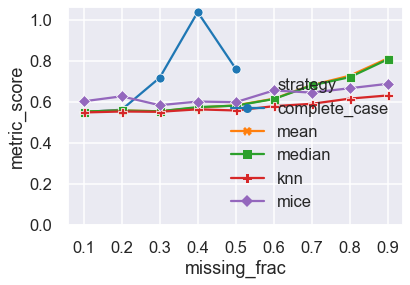

In [51]:
X, y = load_wine()

model = LinearRegression()
metric = metrics.mean_squared_error
missing_fracs = np.linspace(0.1, 0.9, 9)

results_df = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    missingness="mcar",
)

pd.set_option("display.max_rows", results_df.shape[0])
pd.set_option("display.max_columns", results_df.shape[1])
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

feature_col_vs_metric_score(results_df)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()

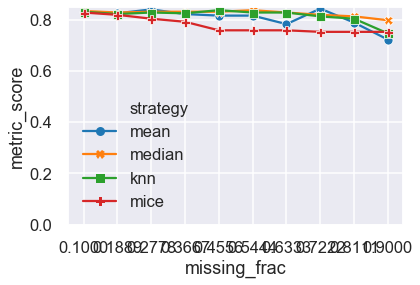

In [52]:
X, y = load_census()

model = RandomForestClassifier(n_estimators=40)
metric = metrics.accuracy_score
missing_fracs = np.linspace(0.1, 0.9, 10)

results_df = experiment(
    X,
    y,
    model=model,
    metric=metric,
    reps=1,
    missing_fracs=missing_fracs,
    missingness="mcar",
)

pd.set_option("display.max_rows", results_df.shape[0])
pd.set_option("display.max_columns", results_df.shape[1])
pd.reset_option("display.max_rows")
pd.reset_option("display.max_columns")

feature_col_vs_metric_score(results_df)
plt.gca().set_ylim(bottom=0)
plt.xticks(missing_fracs)
plt.show()